# Iterative GP

In [3]:
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
import emcee
import corner
import pyDOE
import scipy

# Theory

What I talk about here is also sometimes called **Bayesian Optimzation** or **Bayesian Experimental Design**.

Most of the other notes assume that creating a GP has a few steps:
* Choose training points
* Evaluate the function we are trying to emulate at those points
* Do whatever it is we wanted to do (e.g. posterior inference) using the trained GP.

However, we often don't know where we need to get good training data before we have any. So, this process requires us to collect a large number of samples, many of which will be in really poor positions, to get enough samples in good locations.
An alternative is to first roughly approximate the function with a few samples. Then get more samples in the regions of interest (regions that have a high probability of being high probability). And repeat.

See:
* https://arxiv.org/pdf/1812.04631.pdf
* https://en.wikipedia.org/wiki/Bayesian_optimization
* https://arxiv.org/abs/1807.02811
* https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf

# Exampe

Let's say that we have some observations $y = f(x)$ where we don't know $f$. The observations I have in mind is the [2 point correlation function](../../astro/clustering/main.ipynb) where we measure the excess likelihood as a function of separation.

While we don't fully know $f$, we think we have some model $m(x, \theta)$ that is a good approximation of it ($\Lambda$CDM). We now want to find the parameters $\theta$ for the model that match the observed $y$.

In summary we have,
* **observations**: the true values (that we obtained somehow) for various $x$.
* **model**: a function $m$ that relates $x \rightarrow y$ with some parameters $\theta$.
* **model input**: $\theta$, the parameters to our model.
* **model output**: the values of the model for the given input. Returns something that can be compared to the observations.

## Setup + Truth

In [5]:
# The true parameters + a flat prior
theta_true = np.array([0.5, 1, -2, 3])
theta_prior_range = theta_true[:,np.newaxis] + np.array([-0.1, 0.1])

# The x values for which we have observations
x_range = np.array([-3, 3])
x = np.linspace(x_range[0], x_range[1], num=100)

# This is a really simple model - just a polynomial.
def m(theta, x):
    return np.dot(theta, np.vstack((np.power(x, 3), np.power(x, 2), np.power(x, 1), np.power(x, 0))))

# Our model happens to be right! And so the observations are just an output of the model with some noise
obs_std = 0.1
observations = m(theta_true, x) + np.random.normal(0, obs_std, size=len(x))

We want to find the theta that creates this plot


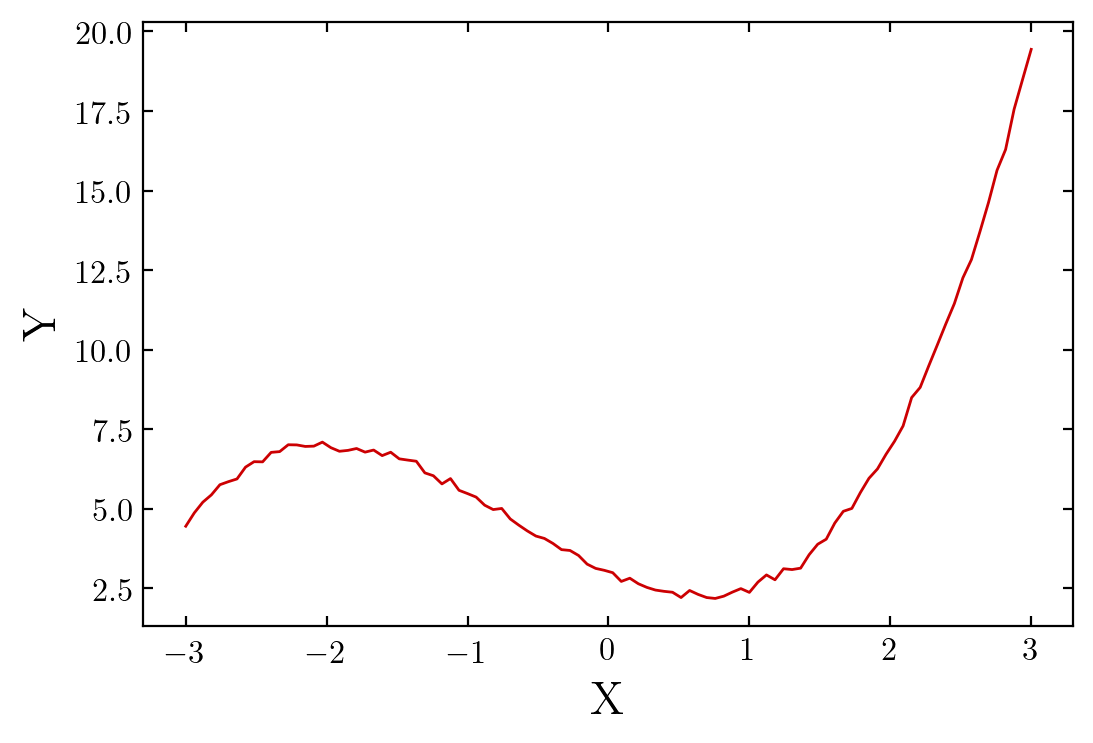

In [6]:
_, ax = plt.subplots()
ax.plot(x, observations)
ax.set(xlabel="X", ylabel="Y")
print("We want to find the theta that creates this plot")

## Likelihood functions

We now need some way to choose the $\theta$ that we think is best. To do that we probabily need some likelihood function $\mathcal{L}(y | \theta$). The exact form of this will depend on the tools we use (MCMC, GP, etc) but I just put all of the likelihood functions here as they are pretty similar. In this notebook we also always end up running an MCMC. There is a general `run_mcmc` that takes as an arg the likelihood function.

Basically, this is just a bunch of helpers that makes the later exposition clearer. Skip to there, then come back to look at the details.

In [7]:
def mcmc_log_likelihood(theta, x, observations, obs_std):
    predictions = m(theta, x)
    return log_likelihood(predictions, theta, observations, obs_std)
    
def gp_log_likelihood(theta, gp_m, observations, obs_std):
    predictions, errors = gp_m.predict(theta[np.newaxis,:])
    predictions = predictions[0]
    errors = errors[0][0] # note that this is variance
    return log_likelihood(predictions, theta, observations, np.sqrt(obs_std**2 + errors)) 

# GP diverge at the edges. So we exclude those regions when we check the uncertainty
tighter_theta_prior = theta_prior_range + (theta_prior_range[:,1] - theta_prior_range[:,0])[:,np.newaxis] * 0.05 * np.array([1, -1])
def gp_log_likelihood_unc(theta, gp_m, observations, obs_std):
    predictions, errors = gp_m.predict(theta[np.newaxis,:])
    predictions = predictions[0]
    errors = errors[0][0]
    
    # see equation 2.3 in https://arxiv.org/pdf/1812.04631.pdf
    # I'm still not really sure why, or comfortable that I am doing this perfectly...
    log_likelihood_unc = 0.5 * np.abs(
        log_likelihood(predictions + np.sqrt(errors), theta, observations, np.sqrt(obs_std**2 + errors)) -
        log_likelihood(predictions - np.sqrt(errors), theta, observations, np.sqrt(obs_std**2 + errors))
    )
    return np.dot(log_likelihood_unc, log_likelihood_unc) # Assuming a diagonal cov matrix

def within_prior(theta, prior):
    if len(theta.shape) == 1:
        return np.all((theta >= theta_prior_range[:,0]) & (theta <= theta_prior_range[:,1]))
    elif len(theta.shape) == 2:
        return np.all((theta >= theta_prior_range[:,0]) & (theta <= theta_prior_range[:,1]), axis=1)
    else:
        raise Exception("What?")
    
def log_likelihood(predictions, theta, observations, obs_std):
    is_in_prior = within_prior(theta, theta_prior_range)
    if len(theta.shape) == 1:
        prior_log_likelihood = 0 if is_in_prior else -1e10
    elif len(theta.shape) == 2:
        prior_log_likelihood = np.zeros(len(theta))
        prior_log_likelihood[np.logical_not(is_in_prior)] = -1e10
    return -0.5 * np.sum(np.log(2 * np.pi * obs_std**2) + np.power(predictions - observations, 2) / obs_std**2, axis=len(theta.shape) - 1) + prior_log_likelihood

def run_mcmc(theta, log_likelihood_func, log_likelihood_args, plot=False):
    ndim, nwalkers = len(theta), 20
    r = np.random.random(size=(nwalkers, ndim))
    theta0 = theta_prior_range[:,0] * r + theta_prior_range[:,1] * (1-r)
    assert np.all(within_prior(theta0, theta_prior_range)), theta0

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_func, args=log_likelihood_args)
    pos, prob, state = sampler.run_mcmc(theta0, 500)
    sampler.reset()
    sampler.run_mcmc(pos, 1000)
    if plot:
        return sampler, plot_chain(sampler)
    return sampler

def plot_chain(sampler):
    return corner.corner(
    sampler.flatchain,
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$", r"$\theta_4$"],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    )

## Straight MCMC

If our model is fast to compute, then we can just run straight MCMC. This is beautifully simple and if you can do it **you should**. Don't get attracted by shiny things and try to use them because they come at some cost (complexity, approximation). End message to self.

(<emcee.ensemble.EnsembleSampler at 0x7fcc043c9710>,
 <Figure size 1940x1940 with 16 Axes>)

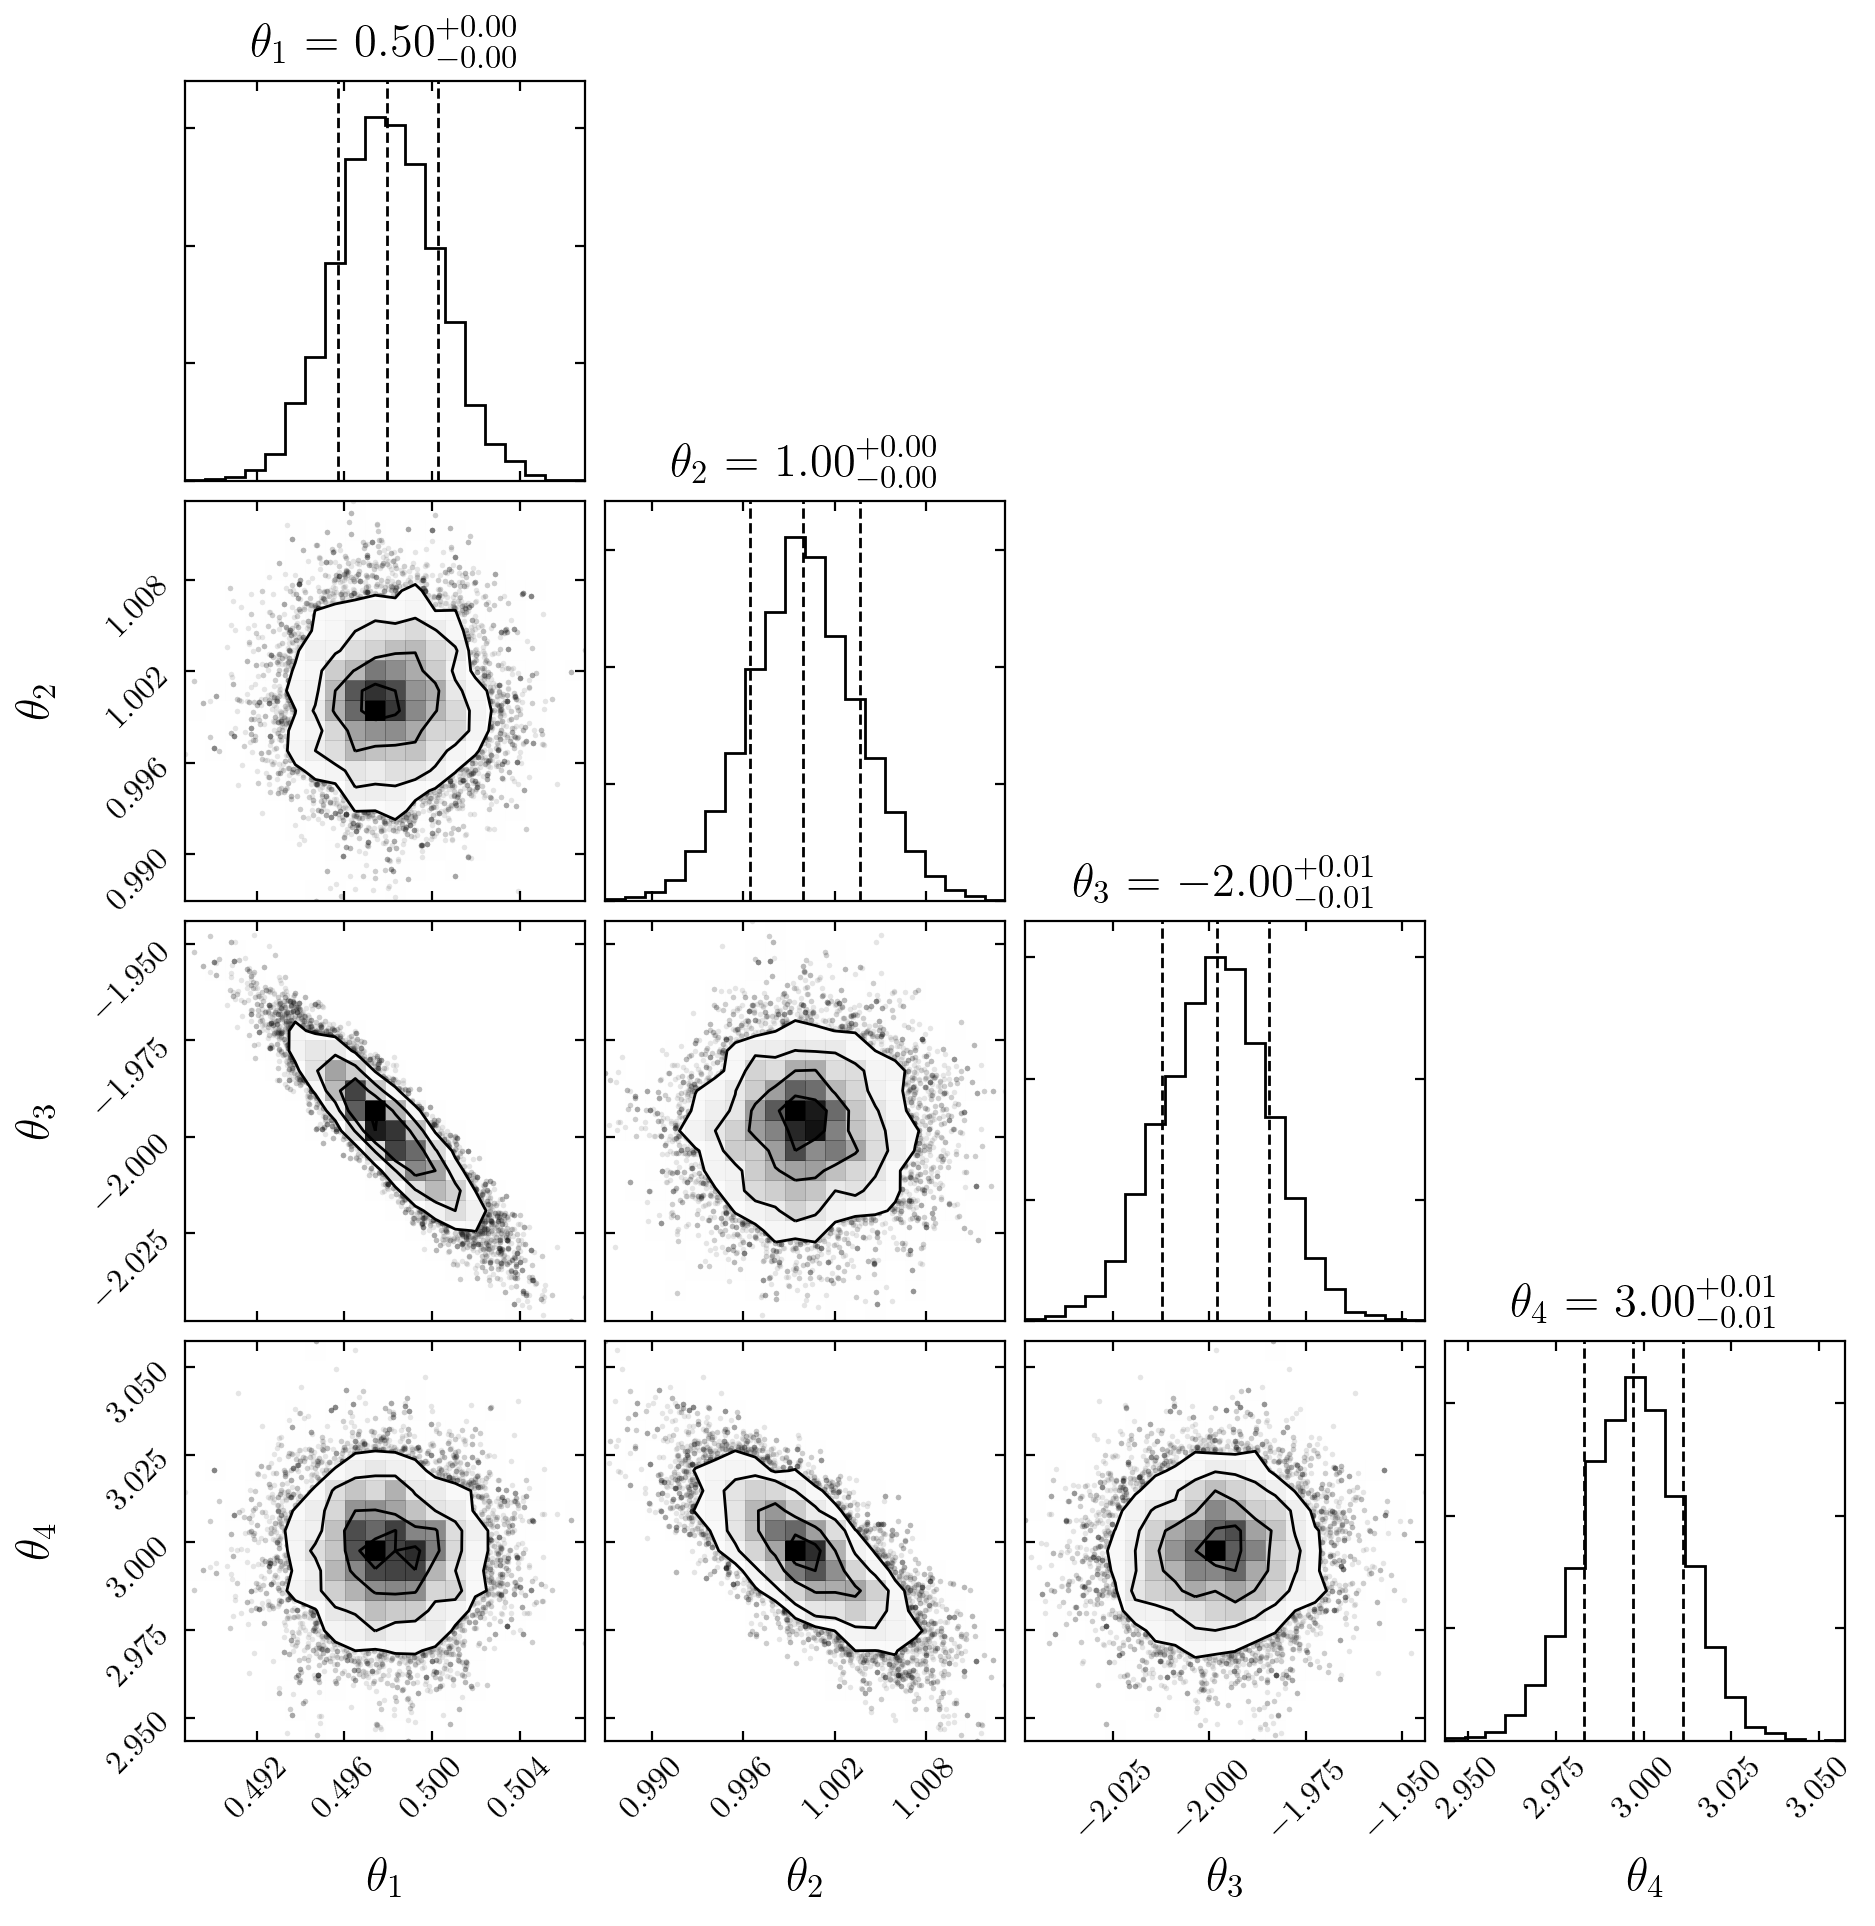

In [8]:
run_mcmc(theta_true, mcmc_log_likelihood, [x, observations, obs_std], True)

## GP

But sometimes MCMC isn't enough. Imagine the model were an N-body simulation. We can't run the ~$10^5$ iterations needed for MCMC to converge. In that case we need to do something cleverer.

Note that we are using the GP to predict the **function**, not the **log likelihood**. See below for why...

[Text(0.5, 1.0, 'Training curves')]

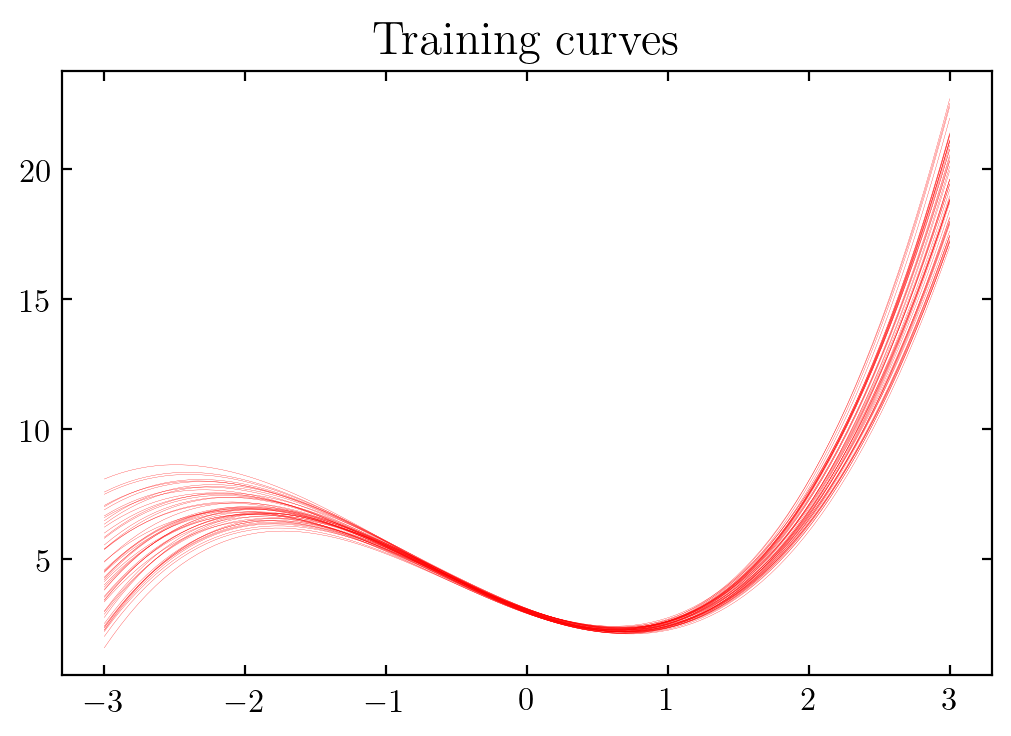

In [9]:
n_training = 50
training_theta = pyDOE.lhs(len(theta_true), n_training) * (theta_prior_range[:,1] - theta_prior_range[:,0]) + theta_prior_range[:,0]

training_y = m(training_theta, x)

_, ax = plt.subplots()
for i in range(len(training_y)):
    plt.plot(x, training_y[i], color="r", linewidth=0.1)
ax.set(title="Training curves")

In [10]:
k = GPy.kern.RBF(len(theta_true), ARD=True)
gp_m = GPy.models.GPRegression(training_theta, training_y, k)
gp_m.optimize(messages=True)

 /home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide


In [11]:
gp_log_likelihood(np.array([0.5, 1, -2, 3.1]), gp_m, observations, obs_std)

40.29426057766964

(<emcee.ensemble.EnsembleSampler at 0x7fcc035fcb70>,
 <Figure size 1940x1940 with 16 Axes>)

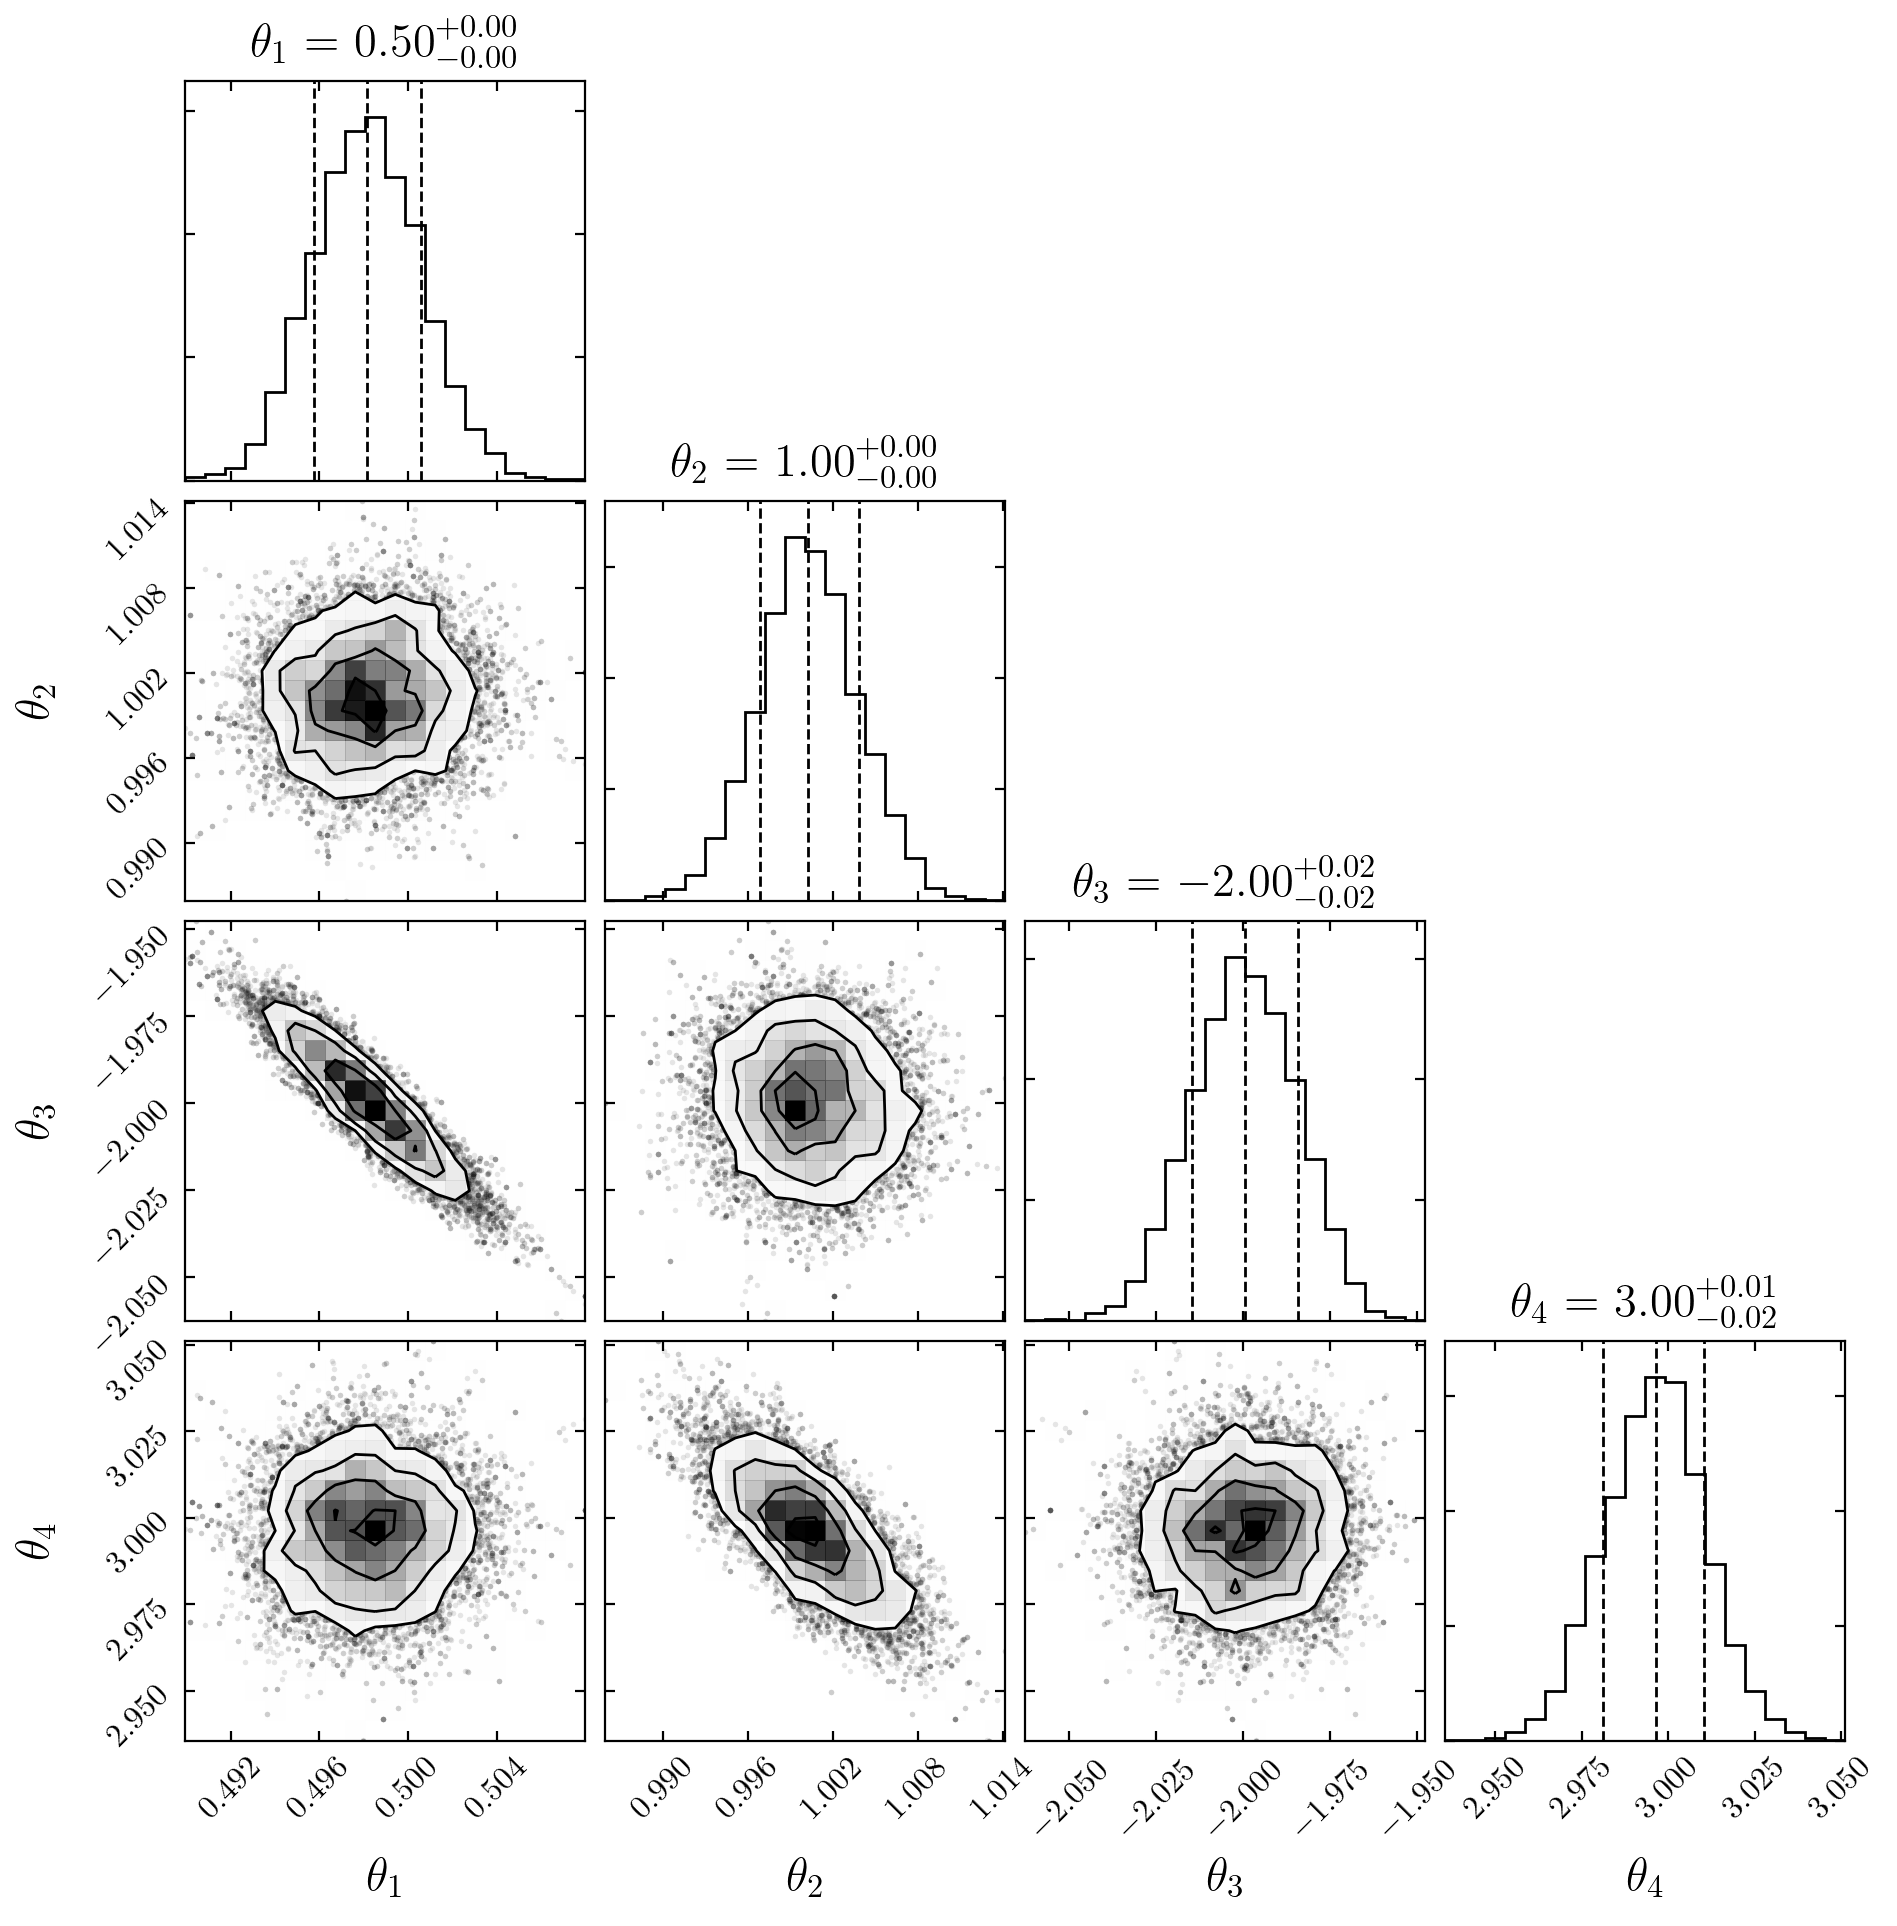

In [12]:
run_mcmc(theta_true, gp_log_likelihood, [gp_m, observations, obs_std], True)

## Iterative GP

Ok that was pretty cool. We got the same results with O(100) function evaluations! But, we probably could have done better. If we use the early function evaluations to pick the later locations more intelligently.

What does intelligently mean? We want to optimize 2 things - we should get data at $\theta$ that:
* We think are regions of high probability
* We don't have well constrained at present

Doing just the first of these could lead us to just hammer away at near to the GP peak. While this is an important region, repeatedly hitting on it doesn't significantly increase our knowledge of the shape of the PDF.
Doing just the second will have us place points in regions of low probability. This will increase our knowledge of the shape of the PDF but in regions that we don't care about.

This can be thought of as an explore-exploit problem. We exploit by choosing places that we think are good, but we explore by choosing places that we don't know well. The extent to which we prefer one or another is parameterized by a hyperparameter $\alpha$. We maximize:

$$
A(\theta) = \mathcal{L}(\theta) + \alpha \sigma(\theta)
$$

where we call $A$ the acquisition function, $\mathcal{L}$ is the likelihood, and $\sigma$ is the uncertainty on the likelihood. If $\alpha = 1$ this selects the location in parameter space where the upper 1 sigma on the likelihood is highest.

Of course to do this process, we need an initial likelihood + uncertainty and so the process looks like:
* Select n initial points (somehow) to get a course estimate of the likelihood surface.
* Iteratively choose points to maximise the acquisition function, until we feel like we know the surface well enough.

What is well enough? I'm not sure...

In [13]:
# Initial training sample
n_training_initial = 5
training_theta = pyDOE.lhs(len(theta_true), n_training_initial) * (theta_prior_range[:,1] - theta_prior_range[:,0]) + theta_prior_range[:,0]

training_y = m(training_theta, x)

alpha = 0.5
k = GPy.kern.RBF(len(theta_true), ARD=True)

n_training_iter = 10
for i in range(n_training_iter):
    # Build current GP
    gp_m = GPy.models.GPRegression(training_theta, training_y, k)
    gp_m.optimize()
    
    
    # Find next point based off current GP
    # This fails sometimes. I just restart from a different point. This is probably fine...
    for i in range(10):
        r = np.random.random()
        res = scipy.optimize.minimize(
            lambda theta: -(gp_log_likelihood(theta, gp_m, observations, obs_std) + alpha * gp_log_likelihood_unc(theta, gp_m, observations, obs_std)),
            tighter_theta_prior[:,0]*r + tighter_theta_prior[:,1]*(1-r), # Just start somewhere in the priors
            bounds=tighter_theta_prior,
        )
        if res.success:
            break
    else:
        print("Failed to optimize /shrug")
    
    # We want to add some random noise to this suggestion so we don't just hammer at the peak at late times
    # We want this noise to be scaled by the posterior. So take the 1 sigma of the marginalized posterior in each dimension.
    # Not sure how to do this so will just add ~0.01 for now
    new_x = res.x + np.random.normal(size=len(res.x)) * 0.01
    
    # Evaluate function at the new x and add to training data
    training_theta = np.append(training_theta, new_x[np.newaxis,:], axis=0)
    training_y = np.append(training_y, m(new_x, x)[np.newaxis,:], axis=0)
    
    # Switch to exploit over time
    alpha -= 0.02

 /home/christopher/.virtualenvs/learning/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


See how we drill down into the region we care about!


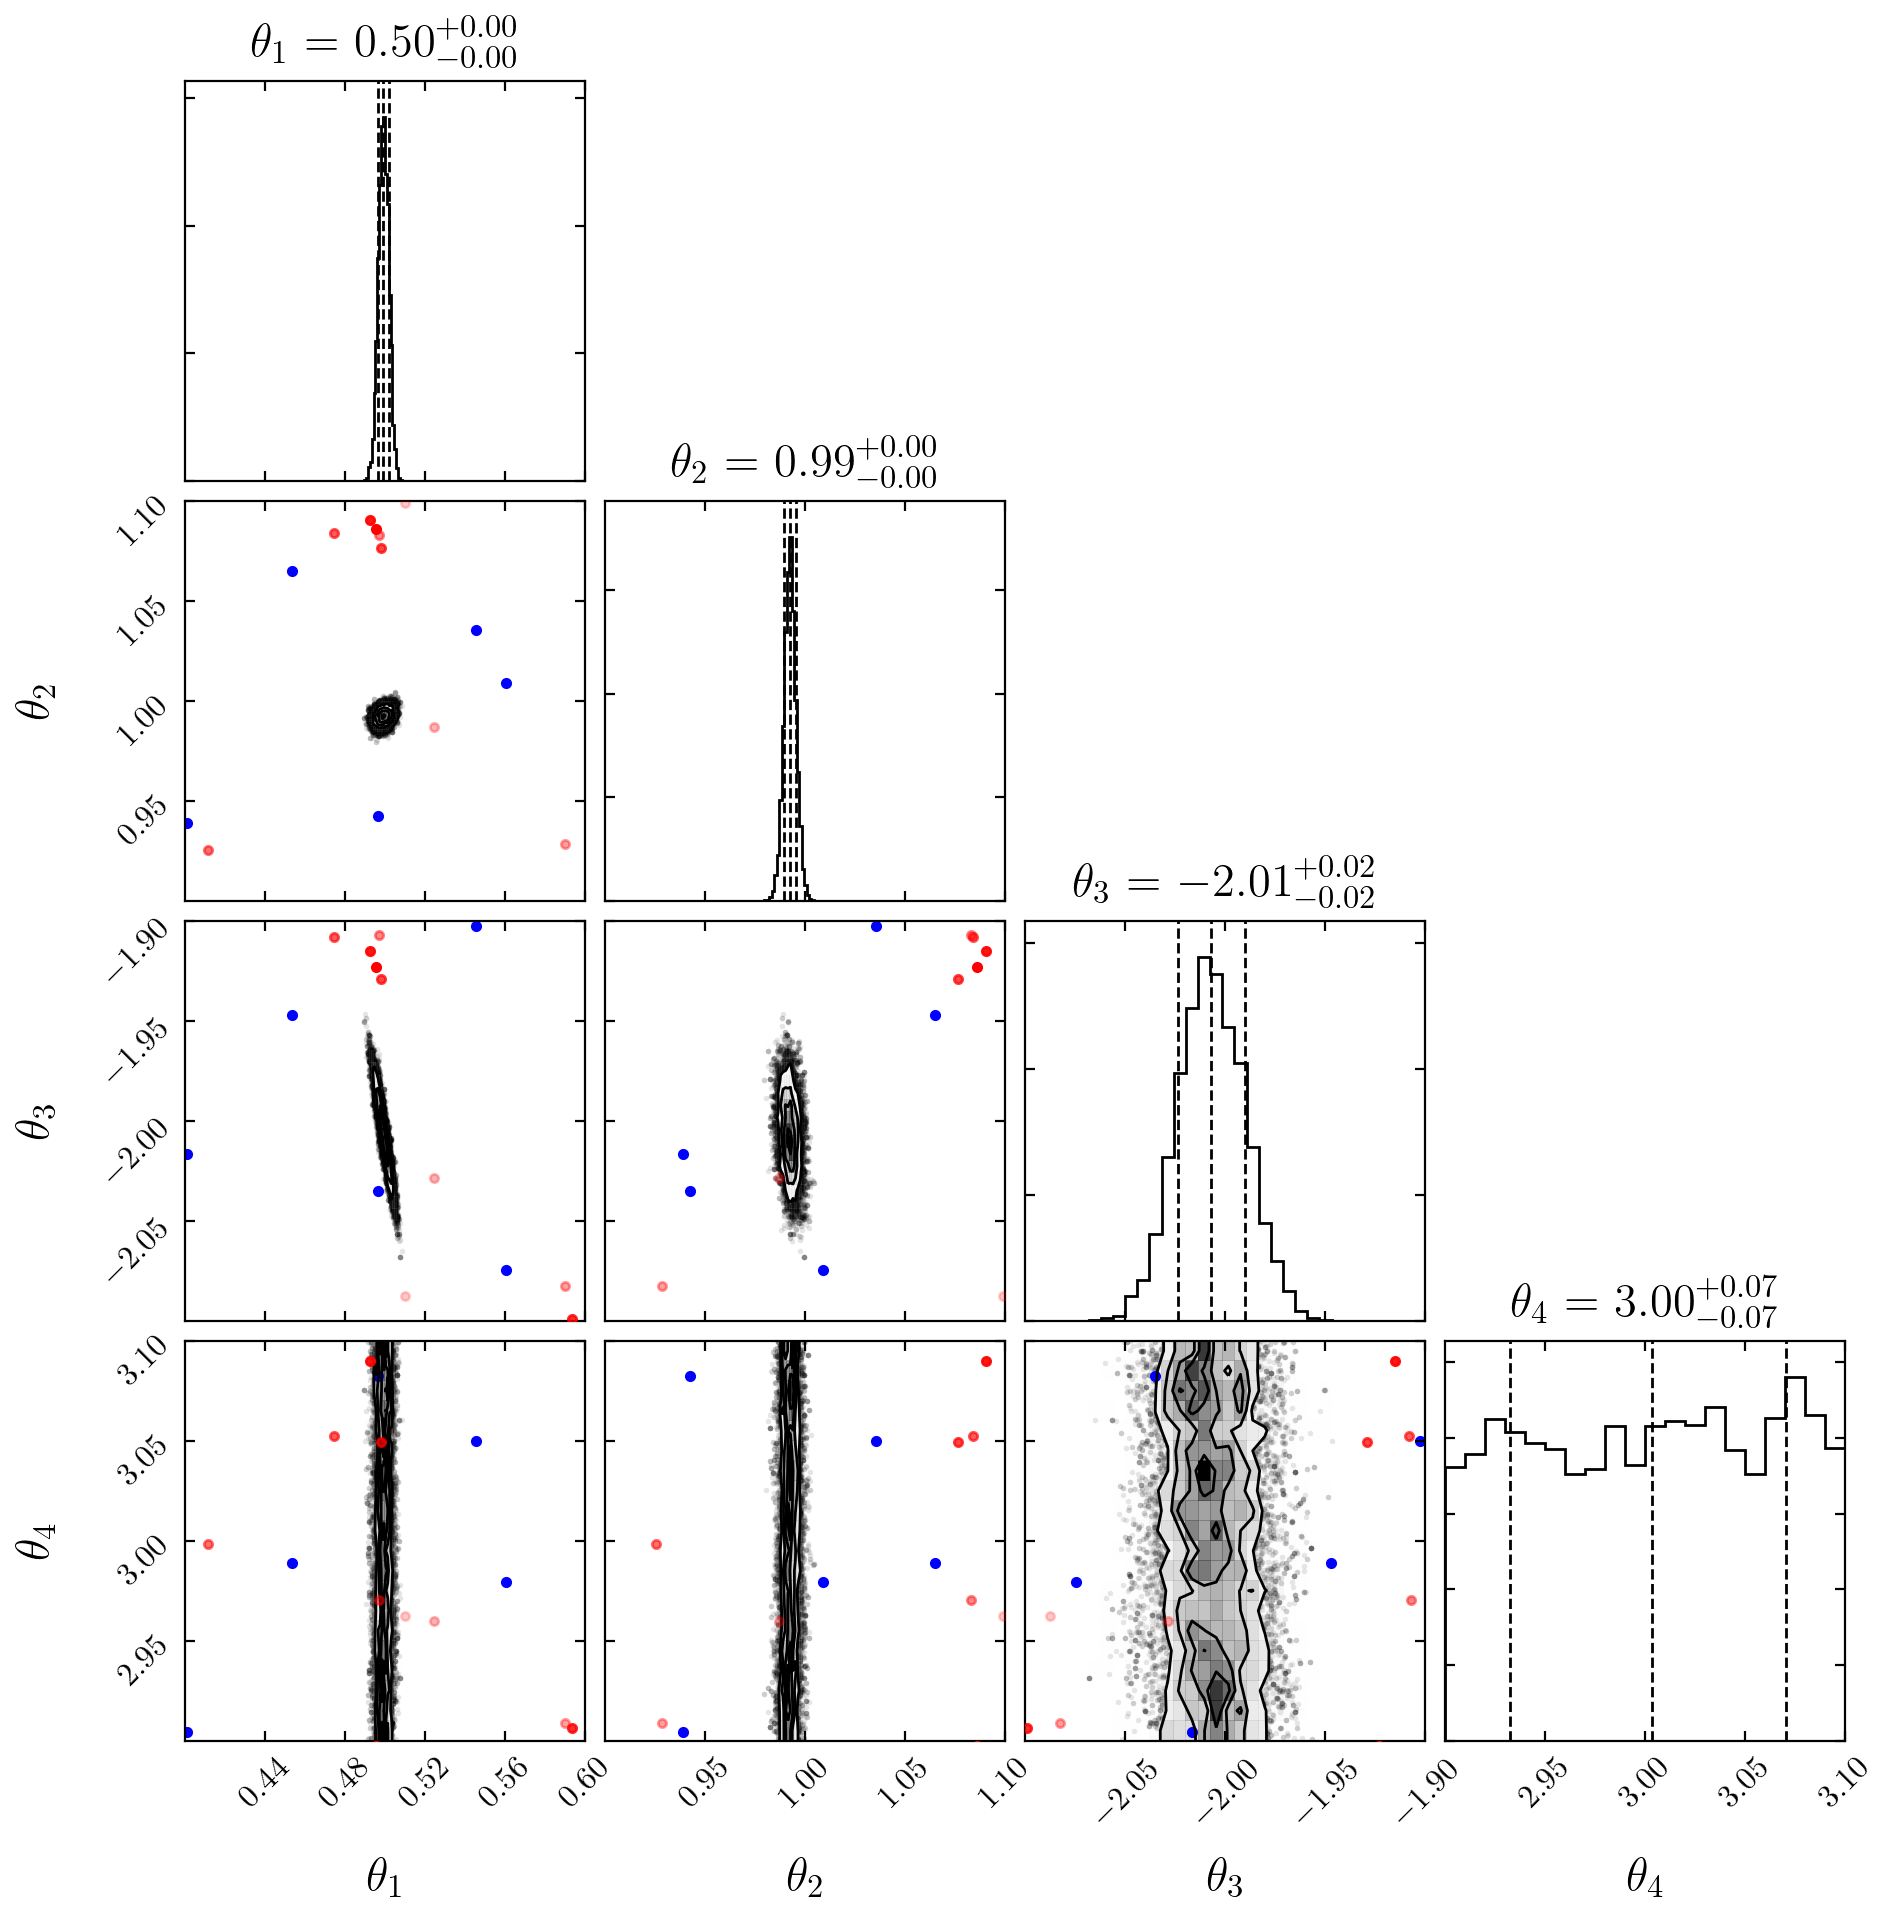

In [14]:
_, fig = run_mcmc(theta_true, gp_log_likelihood, [gp_m, observations, obs_std], True)

for row in range(len(theta_true)):
    for col in range(len(theta_true)):
        if row < col:
            continue
        elif row == col:
            ax = fig.axes[len(theta_true)*row + col]
            ax.set(xlim=theta_prior_range[row])
        else:
            ax = fig.axes[len(theta_true)*row + col]
            ax.scatter(training_theta[:,col][:n_training_initial], training_theta[:,row][:n_training_initial], color="blue")
            for i, alpha in enumerate(np.linspace(0.2, 1, n_training_iter)):
                ax.scatter(training_theta[:,col][n_training_initial + i], training_theta[:,row][n_training_initial + i], color="red", zorder=5, alpha=alpha)
            ax.set(xlim=theta_prior_range[col], ylim=theta_prior_range[row])
print("See how we drill down into the region we care about!")

# Why GP on the observations rather than the Likelihood?

Before doing this, I would just create my GP on the likelihood. My reasoning was, why not - that is what we actually need in the eventual MCMC or maximum likelihood. It also means you are just emulating a single number, rather than a vector which seemed easier.
However, in the [paper](https://arxiv.org/pdf/1812.04631.pdf) I learnt this from they emulate the vector. Why go through that trouble?

I think the answer (which I worked out by doing the test shown below, but actually makes a lot of sense) is that the range on likelihood is **large**. I came across this when creating GPs for the universe machine too. It is not hard to pick parameters that are widly unlikely (at least $-10^{3}$, and in the UM I was getting $-10^{6}$) while the maximum likelihood values are on the order of 0. This is really hard to fit a GP to!

Why is the likelihood range far larger:
* It is made of $(x_i - x)^{2}$, not just $x$.
* It is often the sum of multiple components

The experiment below illustrates this. We generate a grid of the first two $\theta$ values within the priors. We keep the other two params fixed. Then we plot the value of a certain item in the vector and the log likelihoods over that surface. As you can see from the plot of the training samples, at a given $x$, the range of the result is only of order $\sim 5$. The range of the log likelihoods is of order $\sim 5000$!

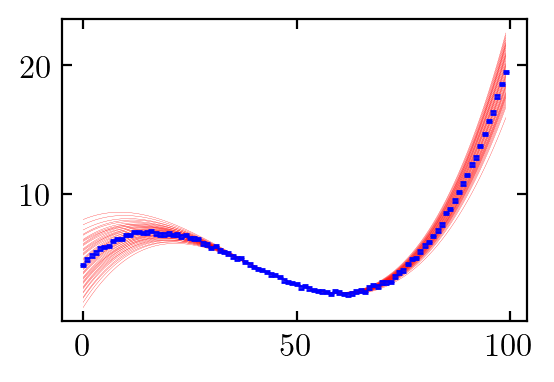

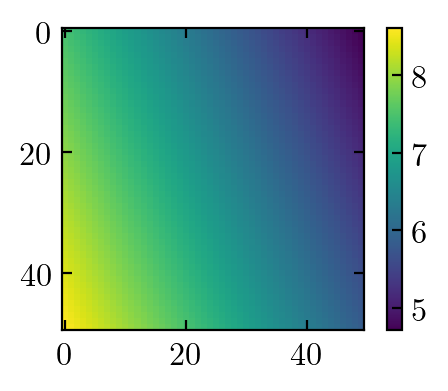

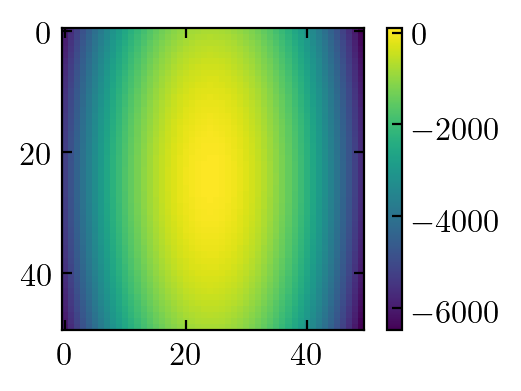

In [15]:
# n_training = 100
theta0, theta1 = np.meshgrid(
    np.linspace(*theta_prior_range[0], num=n_training),
    np.linspace(*theta_prior_range[1], num=n_training)
)
theta2 = np.full((n_training, n_training, 1), theta_true[2])
theta3 = np.full((n_training, n_training, 1), theta_true[3])

training_theta = np.concatenate((theta0[...,np.newaxis], theta1[...,np.newaxis], theta2, theta3), axis=2)
training_theta = training_theta.reshape((-1, len(theta_true)))
training_y = m(training_theta, x)

# Just plot some of the training samples. This shows that the range of outputs is small
fig, ax = plt.subplots(figsize=mpl.small_plotsize)
ax.plot(training_y[::57,:].T, color="r", linewidth=0.1)
ax.errorbar(np.arange(len(observations)), observations, yerr=obs_std, color="b", linewidth=0)

# Now plot all of the training samples for a single x. Change this to show that for any choice, the range is small.
ith_item = 10
fig, ax = plt.subplots(figsize=mpl.small_plotsize)
img = ax.imshow(training_y.reshape((n_training, n_training, -1))[...,ith_item])
fig.colorbar(img)


# The range on the log likelihoods is massive!
ll = log_likelihood(training_y, training_theta, observations, obs_std)
fig, ax = plt.subplots(figsize=mpl.small_plotsize)
img = ax.imshow(ll.reshape((n_training, n_training)))
fig.colorbar(img)